### Header

In [1]:
# import libraries

# maths
import numpy as np
import pandas as pd
import scipy.stats as stats
from pandas.api.types import is_numeric_dtype

# visual
#from matplotlib_venn import venn2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# modelling
from sklearn import linear_model
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,accuracy_score
from sklearn.pipeline import make_pipeline,Pipeline

# nlp
#from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfVectorizer
#from sklearn.naive_bayes import MultinomialNB
#from nltk.stem import PorterStemmer,WordNetLemmatizer
#from nltk.tokenize import sent_tokenize, word_tokenize
#from nltk.corpus import stopwords
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import spacy
#from spacy.tokens import Doc

# web
#import requests
#import json

# others
import os
import re
import time
import datetime as datetime

In [2]:
# file paths

input_path = '../data/2_input/'
clean_path = '../data/3_clean/'
output_path = '../data/4_output/'

image_path = '../images/'

### Functions

### Import Data

In [11]:
# import clean data

df_train = pd.read_csv(clean_path + 'train_clean.csv')
df_test = pd.read_csv(clean_path + 'test_clean.csv')
street_map = gpd.read_file('../data/2_input/Chicago Boundaries/geo_export_d41dc94d-31ce-478c-902c-864695385885.shp')
#df_weather = pd.read_csv(clean_path + 'weather_clean.csv')
df_spray = pd.read_csv(clean_path + 'spray_clean.csv')

### EDA

In [21]:
df_train.head()

,species,block,street,trap,nummosquitos,wnvpresent,year,month,day,latitude,longitude,geometry
0,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,1,0,2007,5,29,41.954690,-87.800991,POINT (-87.800991 41.95469)
1,CULEX RESTUANS,41,N OAK PARK AVE,T002,1,0,2007,5,29,41.954690,-87.800991,POINT (-87.800991 41.95469)
2,CULEX RESTUANS,62,N MANDELL AVE,T007,1,0,2007,5,29,41.994991,-87.769279,POINT (-87.769279 41.994991)
3,CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,1,0,2007,5,29,41.974089,-87.824812,POINT (-87.82481199999999 41.974089)
4,CULEX RESTUANS,79,W FOSTER AVE,T015,4,0,2007,5,29,41.974089,-87.824812,POINT (-87.82481199999999 41.974089)


In [4]:
train_year = list(df_train.year.unique())
train_year

[2007, 2009, 2011, 2013]

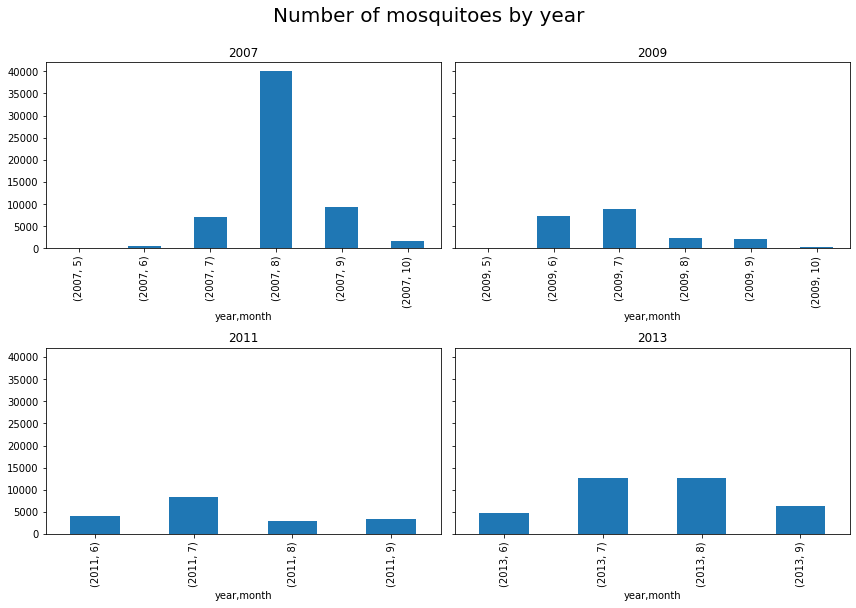

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8),sharey=True)
ax = ax.ravel()
plt.suptitle('Number of mosquitoes by year', fontsize=20, y=1.05)
for i, y in enumerate(train_year):
    df_train[df_train['year']==y].groupby(['year', 'month']).nummosquitos.sum().plot(kind='bar', ax=ax[i])
    ax[i].set_title(y)
plt.tight_layout()

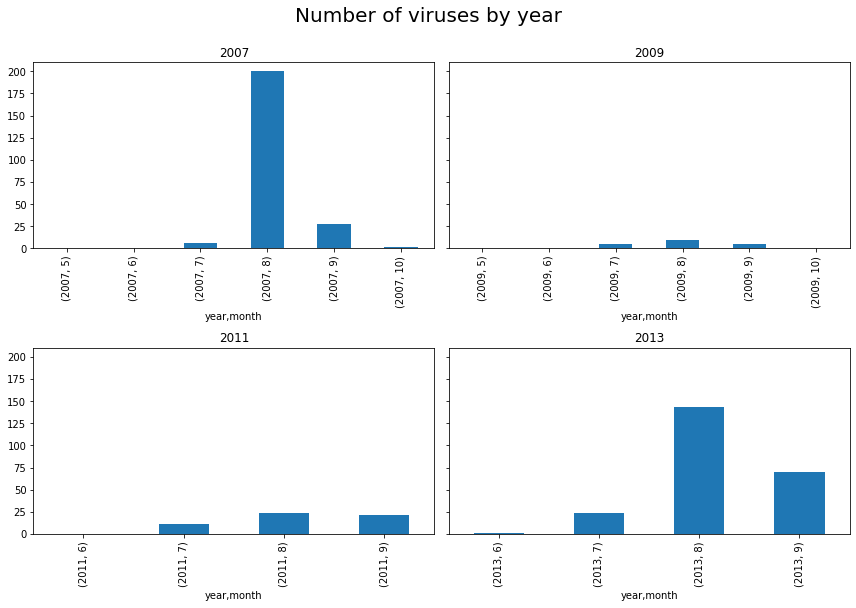

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8),sharey=True)
ax = ax.ravel()
plt.suptitle('Number of viruses by year', fontsize=20, y=1.05)
for i, y in enumerate(train_year):
    df_train[df_train['year']==y].groupby(['year', 'month']).wnvpresent.sum().plot(kind='bar', ax=ax[i])
    ax[i].set_title(y)
plt.tight_layout()

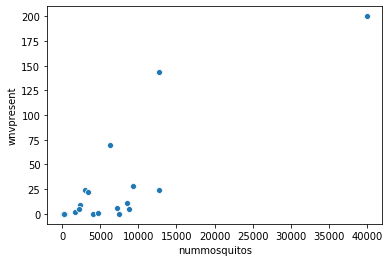

In [35]:
sns.scatterplot(x=df_train.groupby(['year', 'month']).nummosquitos.sum(),
                y= df_train.groupby(['year', 'month']).wnvpresent.sum(),
               data=df_train)

In [22]:
df_spray.head()

,latitude,longitude,year_spray,month_spray,day_spray,geometry
0,42.391623,-88.089163,2011,8,29,POINT (-88.0891633333333 42.3916233333333)
1,42.391348,-88.089163,2011,8,29,POINT (-88.0891633333333 42.3913483333333)
2,42.391022,-88.089157,2011,8,29,POINT (-88.0891566666667 42.3910216666667)
3,42.390637,-88.089158,2011,8,29,POINT (-88.0891583333333 42.3906366666667)
4,42.390410,-88.088858,2011,8,29,POINT (-88.08885833333331 42.39041)


In [25]:
spray_year = list(df_spray.year_spray.unique())
spray_year

[2011, 2013]

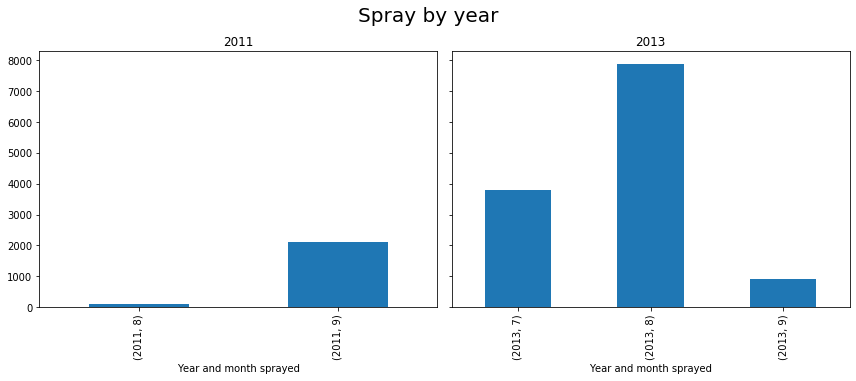

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5),sharey=True)
ax = ax.ravel()
plt.suptitle('Spray by year', fontsize=20, y=1.05)
for i, y in enumerate(spray_year):
    df_spray[df_spray['year_spray']==y].groupby(['year_spray', 'month_spray']).latitude.count().plot(kind='bar', ax=ax[i])
    ax[i].set_title(y)
    ax[i].set_xlabel('Year and month sprayed')
plt.tight_layout()

In [15]:
crs = {'init': 'epsg:4326'}
df_train.head()

,species,block,street,trap,nummosquitos,wnvpresent,year,month,day,latitude,longitude
0,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,1,0,2007,5,29,41.954690,-87.800991
1,CULEX RESTUANS,41,N OAK PARK AVE,T002,1,0,2007,5,29,41.954690,-87.800991
2,CULEX RESTUANS,62,N MANDELL AVE,T007,1,0,2007,5,29,41.994991,-87.769279
3,CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,1,0,2007,5,29,41.974089,-87.824812
4,CULEX RESTUANS,79,W FOSTER AVE,T015,4,0,2007,5,29,41.974089,-87.824812


In [16]:
geometry_train = [Point(xy) for xy in zip(df_train['longitude'], df_train['latitude'])]

geo_df = gpd.GeoDataFrame(df_train,
                      crs=crs,
                      geometry=geometry_train)
geo_df.head()

,species,block,street,trap,nummosquitos,wnvpresent,year,month,day,latitude,longitude,geometry
0,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,1,0,2007,5,29,41.954690,-87.800991,POINT (-87.800991 41.95469)
1,CULEX RESTUANS,41,N OAK PARK AVE,T002,1,0,2007,5,29,41.954690,-87.800991,POINT (-87.800991 41.95469)
2,CULEX RESTUANS,62,N MANDELL AVE,T007,1,0,2007,5,29,41.994991,-87.769279,POINT (-87.769279 41.994991)
3,CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,1,0,2007,5,29,41.974089,-87.824812,POINT (-87.82481199999999 41.974089)
4,CULEX RESTUANS,79,W FOSTER AVE,T015,4,0,2007,5,29,41.974089,-87.824812,POINT (-87.82481199999999 41.974089)


In [17]:
geometry_spray = [Point(xy) for xy in zip(df_spray['longitude'], df_spray['latitude'])]
geo_spray_df = gpd.GeoDataFrame(df_spray,
                      crs=crs,
                      geometry=geometry_spray)
geo_spray_df.head()

,latitude,longitude,year_spray,month_spray,day_spray,geometry
0,42.391623,-88.089163,2011,8,29,POINT (-88.0891633333333 42.3916233333333)
1,42.391348,-88.089163,2011,8,29,POINT (-88.0891633333333 42.3913483333333)
2,42.391022,-88.089157,2011,8,29,POINT (-88.0891566666667 42.3910216666667)
3,42.390637,-88.089158,2011,8,29,POINT (-88.0891583333333 42.3906366666667)
4,42.390410,-88.088858,2011,8,29,POINT (-88.08885833333331 42.39041)


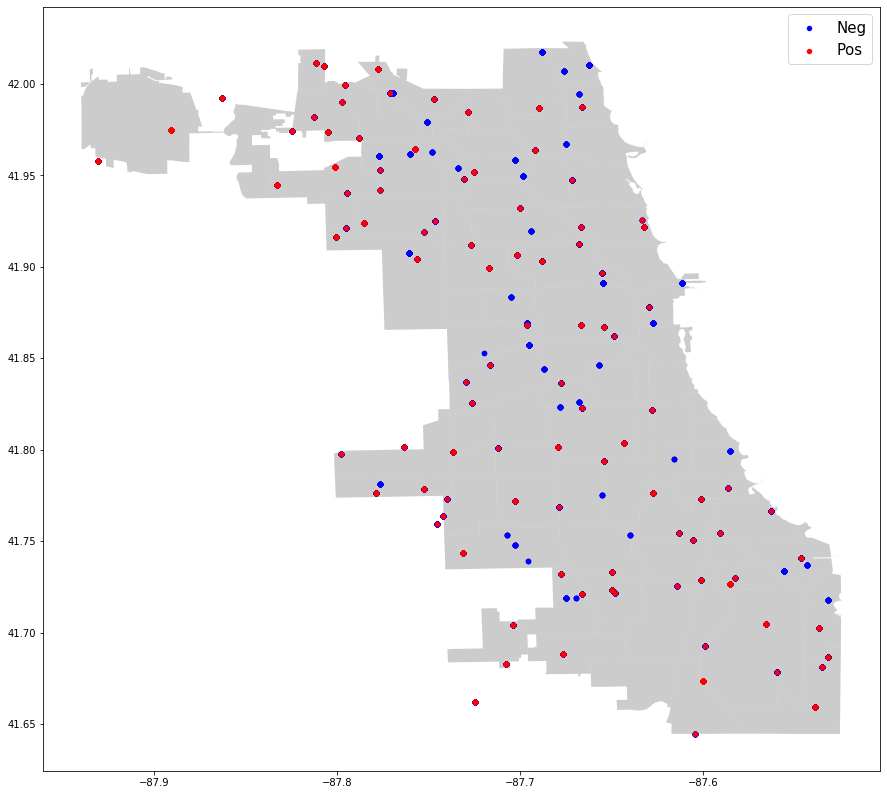

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['wnvpresent']==0].plot(ax=ax, markersize=20, color='blue', marker='o', label='Neg')
geo_df[geo_df['wnvpresent']==1].plot(ax=ax, markersize=20, color='red', marker='o', label='Pos')
plt.legend(prop={'size': 15})

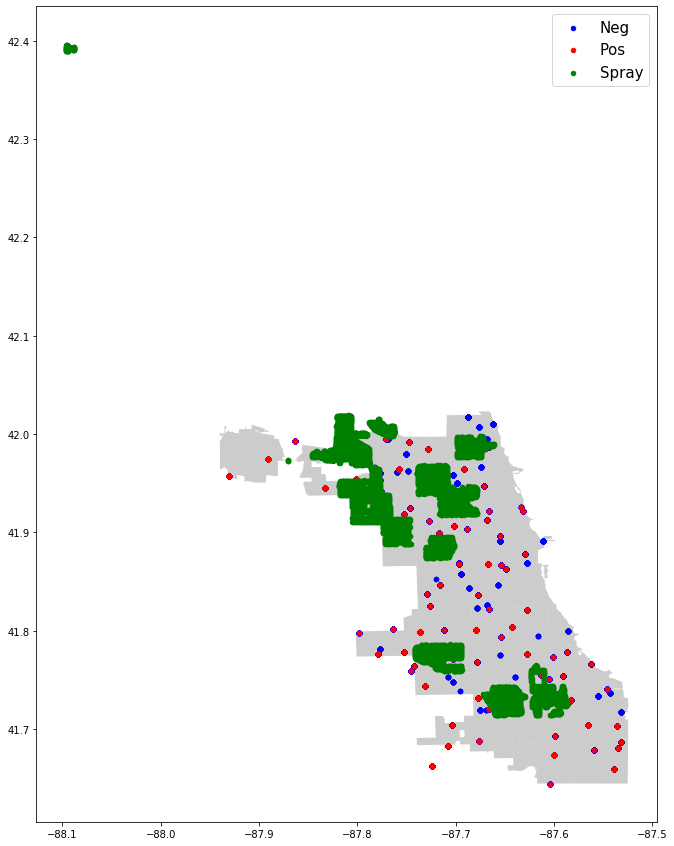

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['wnvpresent']==0].plot(ax=ax, markersize=20, color='blue', marker='o', label='Neg')
geo_df[geo_df['wnvpresent']==1].plot(ax=ax, markersize=20, color='red', marker='o', label='Pos')
geo_spray_df.plot(ax=ax, markersize=20, color='green', marker='o', label = 'Spray')
plt.legend(prop={'size': 15})